In [1]:
from italian_csv_type_prediction.dataframe_generators import SimpleDatasetGenerator
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from multiprocessing import Pool, cpu_count
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.preprocessing import OneHotEncoder
from keras_ding import Ding
from keras_tqdm import TQDMNotebookCallback as ktqdm
import silence_tensorflow.auto

Using TensorFlow backend.


In [2]:
def dataset_generation(number:int):
    return SimpleDatasetGenerator().build(number, verbose=False)

def _dataset_generation(args):
    return dataset_generation(*args)

def parallel_dataset_generation(number:int):
    processes = min(cpu_count()*5, number)
    with Pool(cpu_count()) as p:
        Xs, ys = list(zip(*tqdm(
            p.imap(_dataset_generation, (
                (number//processes, )
                for _ in range(processes)
            )),
            desc="Creating dataset",
            total=processes,
            leave=False
        )))
    return np.vstack(Xs), np.concatenate(ys)

In [3]:
x_train, y_train = parallel_dataset_generation(5000)
x_test, y_test = parallel_dataset_generation(5000)

In [4]:
x_train = x_train.astype(float)
x_test = x_test.astype(float)

In [5]:
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
encode = OneHotEncoder(sparse=False).fit(y_train)
y_train_encoded = encode.transform(y_train)
y_test_encoded = encode.transform(y_test)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.metrics import AUC

model = Sequential([
    Input((x_train.shape[1],)),
    Dense(128, activation="relu"),
    Dense(64, activation="relu"),
    BatchNormalization(),
    Dense(64, activation="relu"),
    Dropout(0.5),
    Dense(y_test_encoded.shape[1], activation="softmax")
])

model.compile(
    "nadam",
    loss="categorical_crossentropy",
    metrics=[
        "accuracy",
        AUC(curve="ROC", name="auroc"),
        AUC(curve="PR", name="auprc")
    ]
)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping

history = model.fit(
    x_train, y_train_encoded,
    epochs=1000,
    batch_size=1024,
    validation_data=(x_test, y_test_encoded),
    verbose=False,
    callbacks=[
        ktqdm(),
        Ding(),
        EarlyStopping(patience=10)
    ]
).history

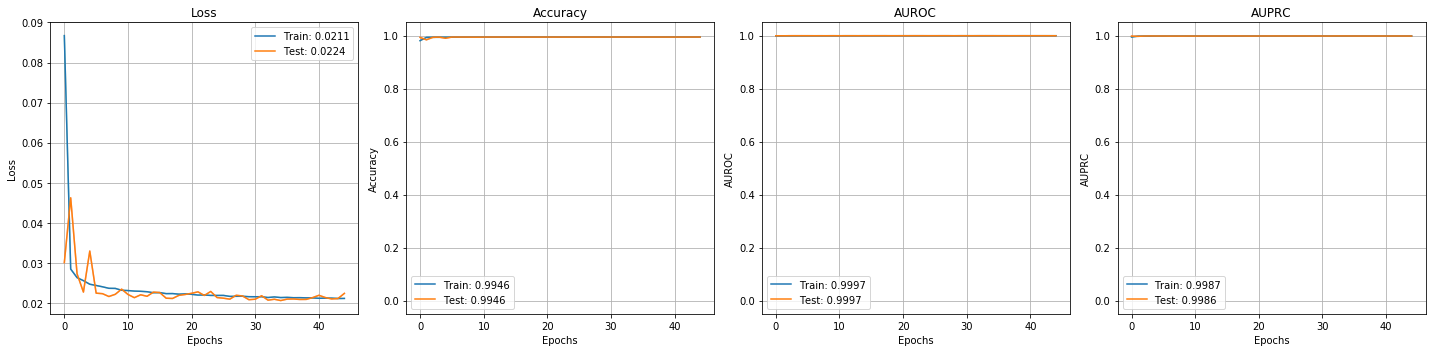

In [9]:
from plot_keras_history import plot_history

plot_history(history)